In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "Data Studies/datasets/Hourly Energy Consumption/"
base_path = "gdrive/MyDrive/" + drive_path

df_PJME_path = base_path + "PJME_hourly.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Energy Consumption - Time Series Forecasting Study

by **Diego Kurashima**

This notebook is a study on the [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data) dataset for **Time Series Forecasting** problems.

## Importing the Data

For this study we'll focus on the **PJM East Region** (**PJME**) data

In [3]:
df_PJME = pd.read_csv(df_PJME_path)
df_PJME['Datetime'] = pd.to_datetime(df_PJME['Datetime'])

print("PJME Data Info:")
print(df_PJME.info())
print("\n")

PJME Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB
None




## Exploratory Analysis (EDA)

First, we'll check for **duplicates** (rows).

In [4]:
print("Check of Duplicates:")
print(f"{df_PJME[df_PJME.duplicated()]}")

Check of Duplicates:
Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []


No duplicates were found. 😀

Now, let's check for **Missing Dates** based on the period in a hourly basis.

In [5]:
pd.date_range(start=df_PJME['Datetime'].iloc[0], end=df_PJME['Datetime'].iloc[-1], freq='h').difference(df_PJME['Datetime'])

DatetimeIndex(['2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00'],
              dtype='datetime64[ns]', freq=None)

Some missing datetime were found. We'll have to handle them later.

### EDA - Overall Analysis

Let's create an **overall plot** of the energy consumption data for the whole period of the dataset.

<ipython-input-6-55160037acbe>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', loc='upper left', fontsize=10)


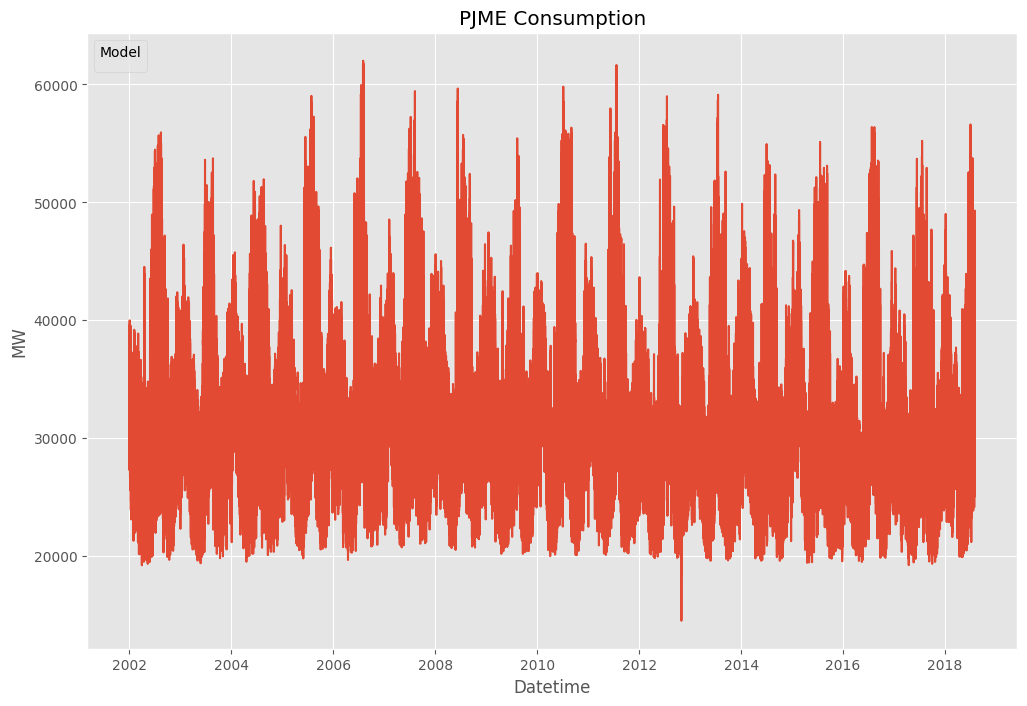

In [6]:
# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME, x='Datetime', y='PJME_MW')

plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Model', loc='upper left', fontsize=10)
plt.grid(True)

Let's get an **overall description** of the data.

In [7]:
df_PJME.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


We'll also plot a **Histogram** and a **Boxplot** to better understand the data.

Text(0.5, 1.0, 'Histogram for MW')

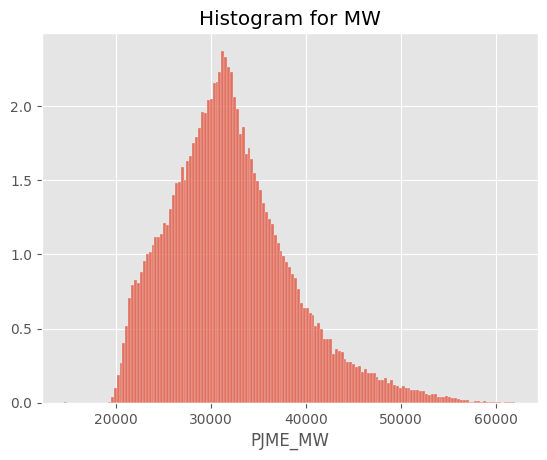

In [8]:
sns.histplot(data=df_PJME, x="PJME_MW", stat='percent')
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Histogram for MW')

Text(0.5, 1.0, 'Boxplot for MW')

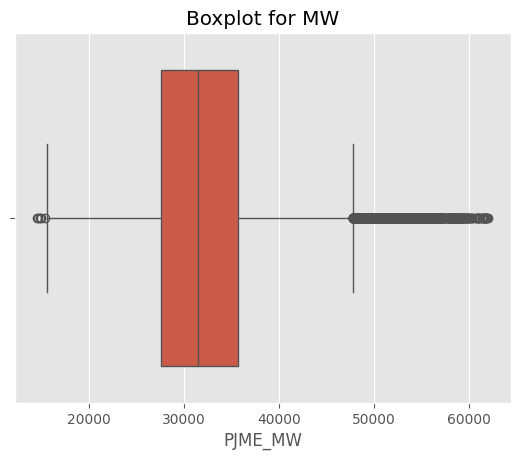

In [9]:
sns.boxplot(data=df_PJME, x="PJME_MW")
plt.xlabel("PJME_MW")
plt.ylabel('')
plt.title('Boxplot for MW')

From the data we may infer the data is slightly skewed (**Positive Skew**). Let's chek the skewness mathematically.

In [10]:
print(f"Skew: {df_PJME['PJME_MW'].skew()}")

Skew: 0.7390115207783634


Since the skew is greater than zero (>0) we confirm that the data for PJME_MW is slightly skewed to the left.

### EDA - Datetime


Since it is a time series data, let's analyse the data based on the datetime: **Year**, **Quarter**, **Month**, **Date**, **Hour**, ...

In addition, let's create feature whether it **Is_Weekend** or not.

We'll also create a feature to show **Season** based on USA Seasons (with full month):
1.  Spring
2.  Summer
3.  Fall
4.  Winter



In [11]:
# Standard Datetime Features
df_PJME['Year'] = df_PJME['Datetime'].dt.year
df_PJME['Quarter'] = df_PJME['Datetime'].dt.quarter
df_PJME['Month'] = df_PJME['Datetime'].dt.month
df_PJME['Day'] = df_PJME['Datetime'].dt.day
df_PJME['Hour'] = df_PJME['Datetime'].dt.hour

df_PJME['Day_of_Year'] = df_PJME['Datetime'].dt.dayofyear

df_PJME['Weekday'] = df_PJME['Datetime'].dt.weekday
df_PJME['Is_Weekend'] =  df_PJME['Datetime'].dt.day_name().isin(['Saturday', 'Sunday'])

# SEASON Feature
def create_feature_Season(row):
  if 3 <= row['Datetime'].month <= 5:
    return 1
  elif 6 <= row['Datetime'].month <= 8:
    return 2
  elif 9 <= row['Datetime'].month <= 11:
    return 3
  else:
    return 4

df_PJME['Season'] = df_PJME.apply(create_feature_Season, axis = 1)
df_PJME['Season_Name'] = df_PJME['Season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

In [12]:
df_PJME.head(5)

,Datetime,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,Season_Name
0,2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,False,4,Winter
1,2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,False,4,Winter
2,2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,False,4,Winter
3,2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,False,4,Winter
4,2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,False,4,Winter


Let's check the effect of Month, Hour and Weekday to the data.

Text(0.5, 1.0, 'PJME_MW by Weekday')

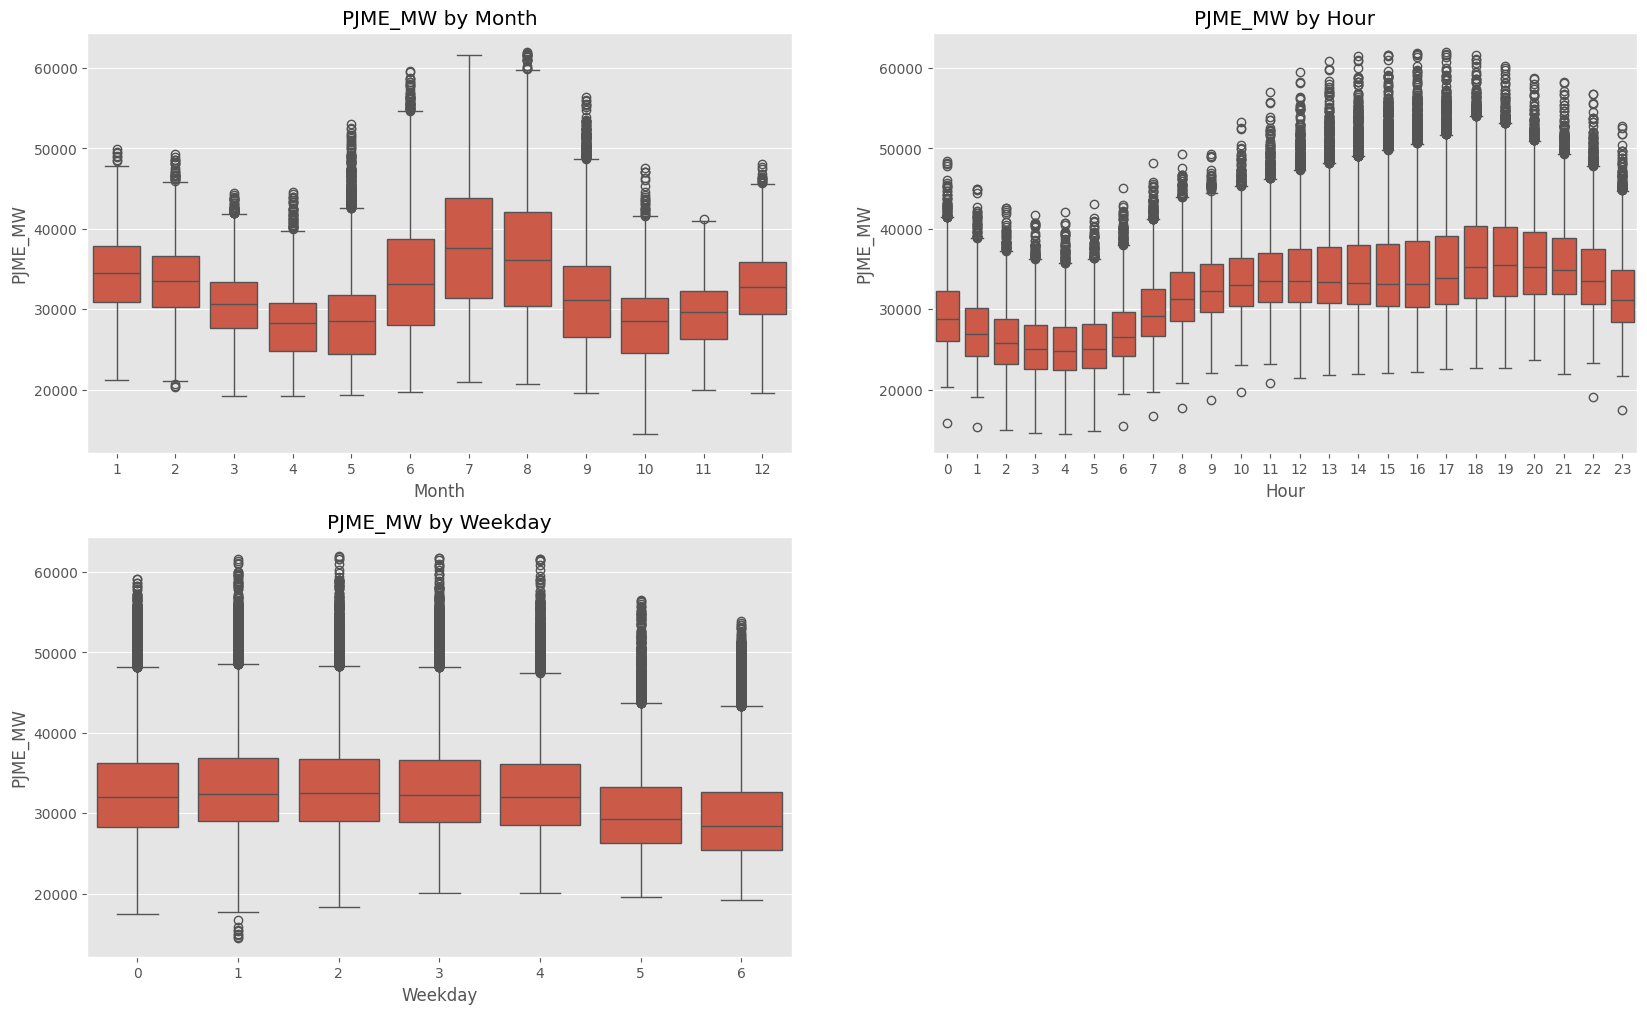

In [21]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Month')
plt.title('PJME_MW by Month')

plt.subplot(2,2,2)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Hour')
plt.title('PJME_MW by Hour')

plt.subplot(2,2,3)
sns.boxplot(data=df_PJME, y='PJME_MW', x='Weekday')
plt.title('PJME_MW by Weekday')

Let's check if the Season affects the distribution of the data.

Text(0.5, 1.0, 'PJME_MW by Season')

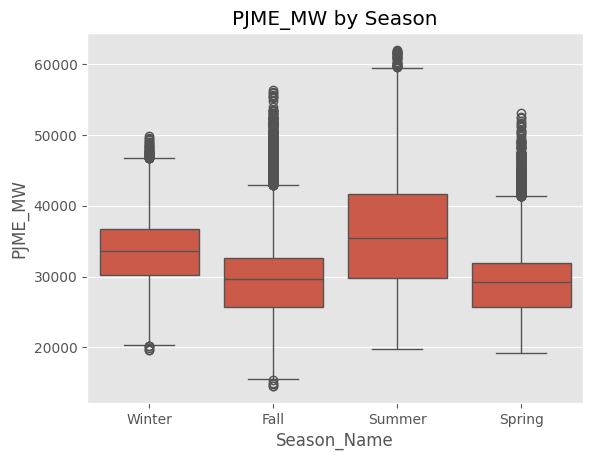

In [14]:
sns.boxplot(data=df_PJME, y="PJME_MW", x='Season_Name')
plt.title('PJME_MW by Season')

### EDA - Time Series Features

Now, we'll analyse the time series components. The main components of a Time Series are:
1.  Trends
2.  Seasonality
3.  Cycles
4.  Residuals

In [15]:
df_PJME_ts = df_PJME.copy()

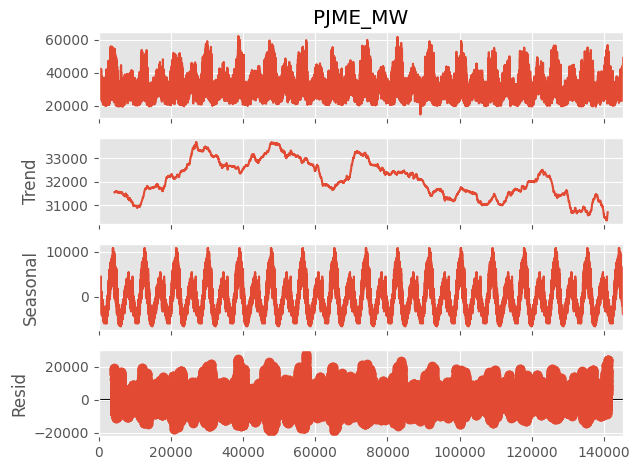

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_PJME['PJME_MW'].interpolate(), model='additive', period=365*24)
result.plot()
plt.show()

Let's start with **Trends**. We'll create a **Rolling Average** for a **1 Year** and **2 Years**.

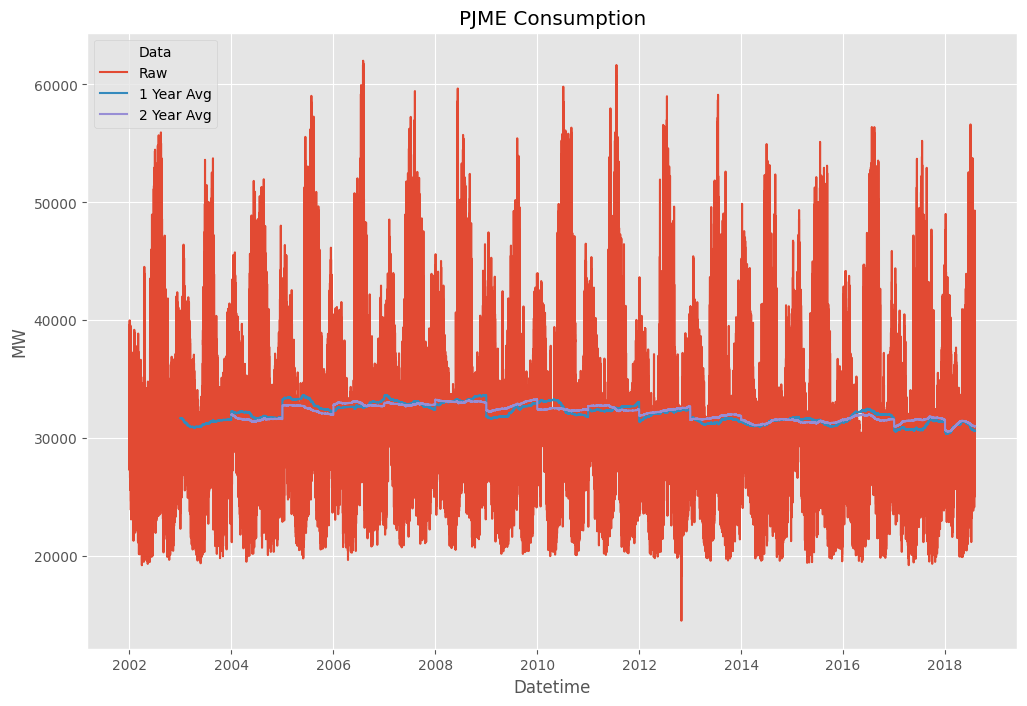

In [17]:
df_PJME_ts[f'PJME_MW_Avg{1}y'] = df_PJME['PJME_MW'].rolling(24*365*1).mean()
df_PJME_ts[f'PJME_MW_Avg{2}y'] = df_PJME['PJME_MW'].rolling(24*365*2).mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_ts, x='Datetime', y='PJME_MW', label ="Raw")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{1}y', label="1 Year Avg")
sns.lineplot(data=df_PJME_ts, x='Datetime', y=f'PJME_MW_Avg{2}y', label="2 Year Avg")

plt.title('PJME Consumption')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)


There isn't any particular increase or decrease in the mean value of PJME_MW, so we may infer the data is stationary.



To analyse **Seasonality**, let's create a **30 days** window to analyse the effects of a **monthly seasonality**.

<ipython-input-48-88a3890b77ea>:4: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


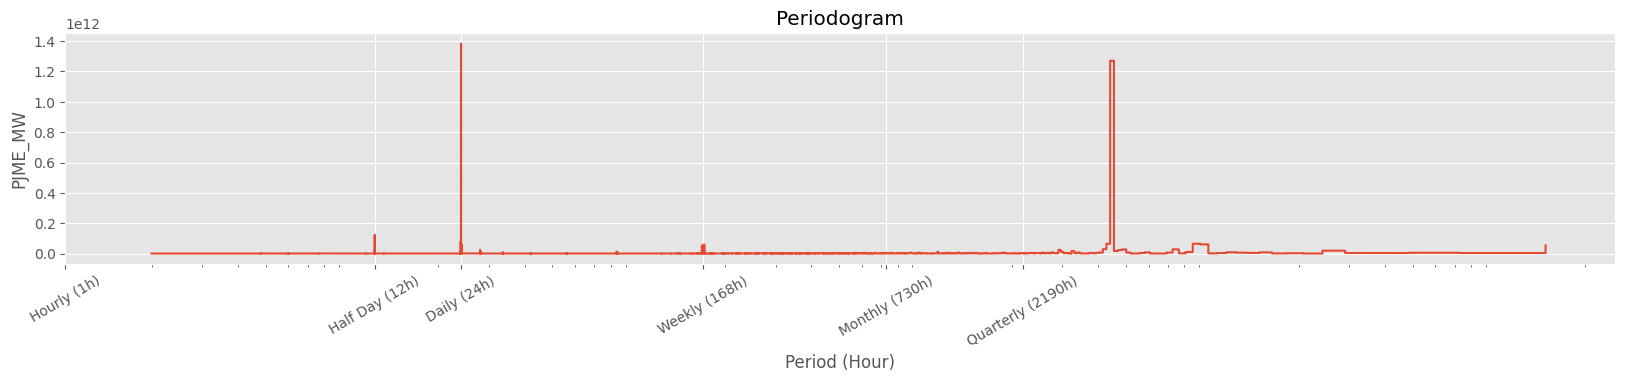

In [48]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df_PJME['PJME_MW'].interpolate())
periods = 1 / frequencies

fig, ax = plt.subplots(figsize=(20, 3))
ax.step(periods, spectrum)
ax.set_title('Periodogram')
ax.set_xscale('log')
ax.xaxis.set_major_formatter('{x:,.0f}')

periods_featured = [1, 12, 24, 24*7, int(24*365/12), int(24*365/4)]
ax.set_xticks(periods_featured)
ax.set_xticklabels(["Hourly (1h)",
                    "Half Day (12h)",
                    f"Daily (24h)",
                    f"Weekly ({periods_featured[3]}h)",
                    f"Monthly ({periods_featured[4]}h)",
                    f"Quarterly ({periods_featured[5]}h)"],
        rotation=30,
    )
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.xlabel('Period (Hour)')
plt.ylabel('PJME_MW')
plt.show()

Let's create a **30 days** window to analyse the effects of a **Quarterly** seasonality.

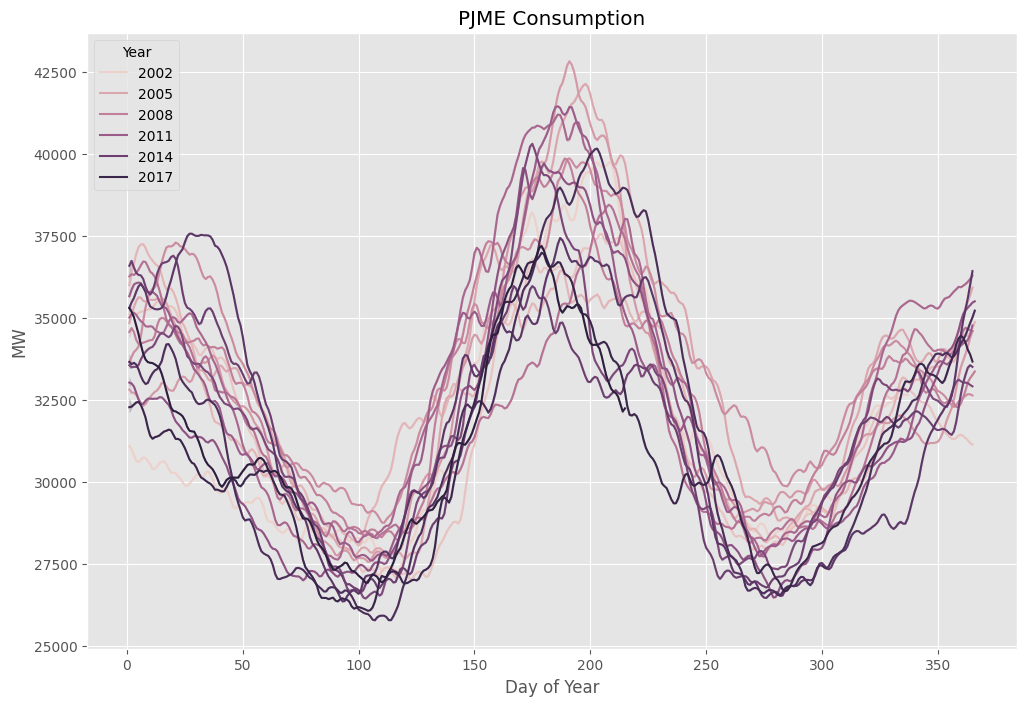

In [18]:
df_PJME_ts[f'PJME_MW_Avg{30}d'] = df_PJME['PJME_MW'].rolling(24*30).mean()

# Plots
plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_ts, x='Day_of_Year', y=f'PJME_MW_Avg{30}d', hue = 'Year')

plt.title('PJME Consumption')
plt.xlabel('Day of Year')
plt.ylabel('MW')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

As for **Cycles**. Let's plot **Autocorrelation** and **Partial Autocorrelation**.

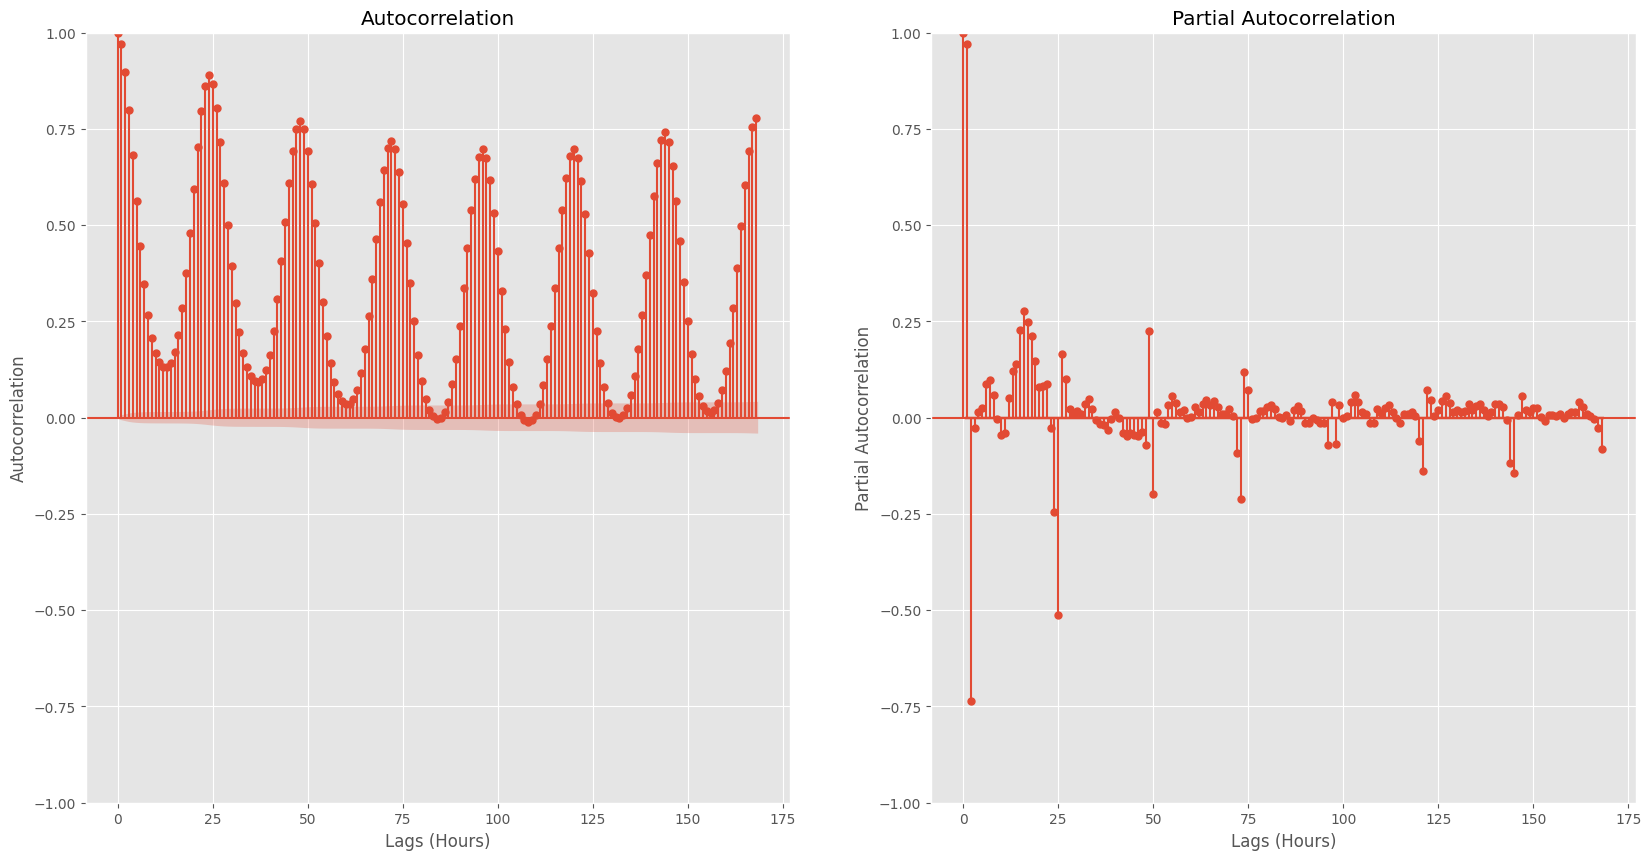

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plots
fig, ax = plt.subplots(1,2, figsize=(20, 10))

#plt.subplot(2,2,1)
plot_acf(df_PJME['PJME_MW'], lags=24*7, ax=ax[0])
ax[0].set_title('Autocorrelation')
ax[0].set_xlabel('Lags (Hours)')
ax[0].set_ylabel('Autocorrelation')
ax[0].grid(True)

#plt.subplot(2,2,2)
plot_pacf(df_PJME['PJME_MW'], lags=24*7, ax=ax[1])
ax[1].set_title('Partial Autocorrelation')
ax[1].set_xlabel('Lags (Hours)')
ax[1].set_ylabel('Partial Autocorrelation')
#plt.legend(title='Model', loc='upper left', fontsize=10)
ax[1].grid(True)


We'll start with **Windowed Statistics**. Let's start creating a **Rolling Average** of MW. Let's choose a window of 24 hours and another of 7 days (168 hours). Let's plot the time series for 2006.

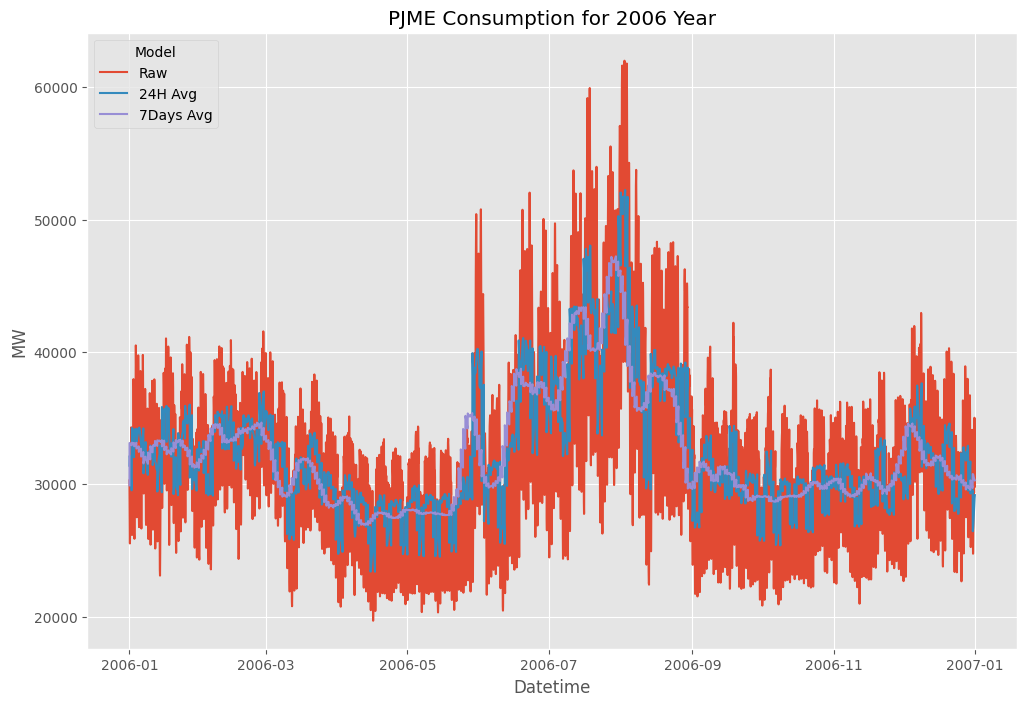

In [20]:
df_PJME[f'PJME_MW_Avg{24}h'] = df_PJME['PJME_MW'].rolling(24).mean()
df_PJME[f'PJME_MW_Avg{24*7}h'] = df_PJME['PJME_MW'].rolling(24*7).mean()

# Plots
df_PJME_sliced = df_PJME[df_PJME['Datetime'].dt.year == 2006]

plt.figure(figsize=(12, 8))

sns.lineplot(data=df_PJME_sliced, x='Datetime', y='PJME_MW', label ="Raw")
sns.lineplot(data=df_PJME_sliced, x='Datetime', y=f'PJME_MW_Avg{24}h', label="24H Avg")
sns.lineplot(data=df_PJME_sliced, x='Datetime', y=f'PJME_MW_Avg{24*7}h', label="7Days Avg")

plt.title('PJME Consumption for 2006 Year')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Model', loc='upper left', fontsize=10)
plt.grid(True)